<a href="https://colab.research.google.com/github/hwarang97/Image_classification/blob/main/VGG16_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG
- 16, 19 등 뒤에 붙는 숫자는 구성된 층의 갯수
- 쉬운 구조와 성능 덕분에 우승모델(Googlenet)보다 인기가 더 많음
- 핵심
  - 모델 깊이와 성능의 관계 파악
    - 더 깊이 만들기 위해서 커널을 3x3을 고정
    - 큰 필터를 한번 적용하는것보다 작은 필터를 여러번 적용하는것이 성능은 같은데 파라미터 수가 더 적음
    - 작은 필터를 적용하니 비선형성이 증가하여 특성을 잘 나타냄

- input : 224 x 224 x 3

In [ ]:
from torch.nn.modules.activation import Softmax 
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import * 
from torch.nn.modules import dropout
from torch.nn.modules.adaptive import Linear
from torch.nn.modules.pooling import MaxPool2d
import os

In [1]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 

NameError: ignored

In [ ]:
# # Retrieve data directly from Stanford data source
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

# # Unzip raw zip file
# !unzip -qq 'tiny-imagenet-200.zip'

--2022-12-29 13:33:40--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.8MB/s    in 7.3s    

2022-12-29 13:33:48 (32.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [ ]:
# # Define main data directory
# DATA_DIR = 'tiny-imagenet-200'

# # Define training and validation data paths
# TRAIN_DIR = os.path.join(DATA_DIR, 'train')
# TEST_DIR = os.path.join(DATA_DIR, 'test')

# training_data = datasets.ImageFolder(root = TRAIN_DIR, 
#                                      transform=transforms.Compose([ # transform : 이미지 특징들에 적용
#                                          Resize(224),
#                                          ToTensor(), # 텐서로 만들고, 0~1 사이 값으로 스케일링
#                                      ]))
# test_data = datasets.ImageFolder(root = TEST_DIR, transform=transforms.Compose([
#                                          Resize(224),
#                                          ToTensor(),
#                                      ]))

# sample = training_data[0][0]
# print(sample.shape, sample.dtype, sample.max(), sample.min()) # 제대로 변환되었는지 확인

torch.Size([3, 224, 224]) torch.float32 tensor(1.) tensor(0.0235)


데이터가 문제인지 모델이 문제인지, fashion으로 새로 만들어보고 제대로 학습하는지 확인해보자.

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=32) # batch_size가 작으니까 너무 불안정하다. 128정도 이상은 되야하지 않을까
test_dataloader = DataLoader(test_data, batch_size=32)

### 추가학습
- 직접 데이터셋을 구성하고 불러오는 방법
- https://data-panic.tistory.com/13

- 참조한 페이지(tiny-imagenet-200 관련)
- https://towardsdatascience.com/pytorch-ignite-classifying-tiny-imagenet-with-efficientnet-e5b1768e5e8f

In [ ]:
class VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    """Conv layers"""
    self.conv_relu_stack = nn.Sequential(
        nn.Conv2d(3, 64, 3, padding=1),   # conv1_1
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding=1),  # conv1_2
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3, padding=1), # conv2_1
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding=1), # conv2_2
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(128, 256, 3, padding=1), # conv3_1
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1), # conv3_2
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1), # conv3_3
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(256, 512, 3, padding=1), # conv4_1
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding=1), # conv4_2
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding=1), # conv4_3
        nn.ReLU(),
        nn.MaxPool2d(2),    
        nn.Conv2d(512, 512, 3, padding=1), # conv5_1
        nn.ReLU(),           
        nn.Conv2d(512, 512, 3, padding=1), # conv5_2
        nn.ReLU(),          
        nn.Conv2d(512, 512, 3, padding=1), # conv5_3
        nn.ReLU(),
        nn.MaxPool2d(2),
    )

    """FC layers"""
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(7*7*512, 4096),  
        nn.ReLU(),
        nn.Dropout(0.5),        # 드롭 아웃은 왜 활성화 다음에 쓸까, 전에 쓰면 계산할것도 줄어들지 않나
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096,1000)
    )

  def forward(self, x):
    x1 = self.conv_relu_stack(x)
    x2 = self.flatten(x1)
    logits = self.linear_relu_stack(x2)
    return logits

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for step, (X, y) in enumerate(dataloader, 1): # 전체 이미지를 batch_size만큼 묶어서 전달
    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad() # 전에 역전파로 얻었던 w 기울기를 0으로 만들어주기. 안그러면 누적되어 점점커짐
    loss.backward() # 역전파
    optimizer.step() # 오차에 기여한 만큼 파라미터를 갱신

    if step % 10 == 0:
      loss, current = loss.item(), step * len(X)
      print(f'loss : {loss:>7f} [{current:>5d}/{size:>5d}]')


def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad(): # grad를 저장하지 않음
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item() # 오차값을 누적
      correct += (pred.argmax(1)==y).type(torch.float).sum().item() # 몇개 맞췄는지 기록

  test_loss /= num_batches # loss 값의 평균
  correct /= size          # 정확도 평균
  print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n') # 0.1f는 뭐지 -> 소수점 한자리까지 표현(?)

In [ ]:
model = VGG16().to(device)
print(model)

VGG16(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

##### 추가 학습
- print f format의 정렬기능
  - 중괄호{}안에 변수 옆에 : 를 입력
  - < : 왼쪽정렬
  - \> : 오른정렬
  - \^ : 중앙정렬
  - 숫자 : 몇칸으로 표현할지

In [ ]:
learning_rate = 1e-2
epochs = 1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # 미니배치면 불완전하지만 SDG보다는 빠르게 최적 파라미에 도달한다

for t in range(epochs):
  print(f'Epoch {t+1}\n-----------------------------')
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn)
print('DONE!!!!!!!!!!!!!!!!!!!!!!!') # GPU RAM 값이 부족하면 kernel을 restart해보고, 그래도 찼다면 batch_size를 줄이고 이걸 반복

Epoch 1
-----------------------------
loss : 6.775857 [  320/100000]
loss : 6.854997 [  640/100000]
loss : 6.713550 [  960/100000]
loss : 6.812537 [ 1280/100000]
loss : 6.888543 [ 1600/100000]
loss : 6.743188 [ 1920/100000]
loss : 6.814485 [ 2240/100000]
loss : 6.891642 [ 2560/100000]
loss : 6.743404 [ 2880/100000]
loss : 6.846145 [ 3200/100000]
loss : 6.819551 [ 3520/100000]
loss : 6.748758 [ 3840/100000]
loss : 6.846713 [ 4160/100000]
loss : 6.690723 [ 4480/100000]
loss : 6.764525 [ 4800/100000]
loss : 6.847092 [ 5120/100000]
loss : 6.681594 [ 5440/100000]
loss : 6.782244 [ 5760/100000]
loss : 6.902182 [ 6080/100000]
loss : 6.731118 [ 6400/100000]
loss : 6.814731 [ 6720/100000]
loss : 6.912586 [ 7040/100000]
loss : 6.725810 [ 7360/100000]
loss : 6.822799 [ 7680/100000]
loss : 6.621541 [ 8000/100000]
loss : 6.705748 [ 8320/100000]
loss : 6.850522 [ 8640/100000]
loss : 6.616325 [ 8960/100000]
loss : 6.721533 [ 9280/100000]
loss : 6.850364 [ 9600/100000]
loss : 6.530475 [ 9920/100000]
l

### Fashion MNIST 이미지를 활용하는 방법

In [37]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [23]:
training_data = torchvision.datasets.FashionMNIST( # (60000, 28, 28)
    root='./data/',
    train = True,
    transform = ToTensor(),
    download=True,
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data/',
    train=False,
    transform=ToTensor(),
    download=True,
)

train_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

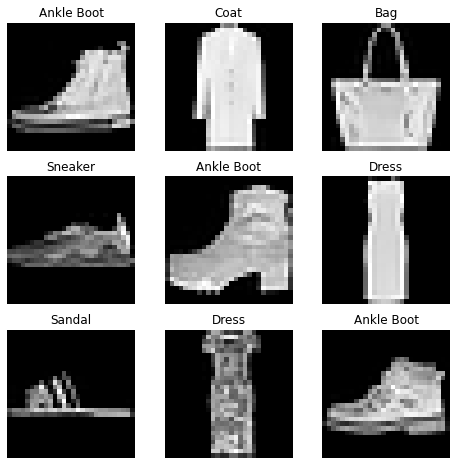

In [48]:
# 데이터셋이 제대로 들어갔는지 시각화해서 확인

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows*cols+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item() # Tensor에서 값이 하나만 있는 걸 꺼낼때 사용
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off') # 축 눈금등을 없애주는 메소드, 기본값:True
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [49]:
import os
import pandas as pd
from torchvision.io import read_image # ???

In [ ]:
class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):